In [ ]:
%pip install numpy opencv-python scikit-learn matplotlib scikit-image


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Memuat dan memproses citra dari database...
Training K-Means untuk kuantisasi warna...
Ekstraksi fitur dari semua patch...
Berhasil memuat 2800 patch citra dari 112 kelas.
Analisis Fitur:
- LBP Histogram: 18 fitur
- Maximum Run Length: 1 fitur
- Color Histogram: 64 fitur
- Mean Colors: 3 fitur
- Std Colors: 3 fitur
Total fitur: 89
Melatih model CBIR...
Model berhasil dilatih menggunakan metric: canberra
Evaluasi performa sistem...
Hasil evaluasi (k=5):
  Rata-rata Precision: 0.9918
  Rata-rata Recall:    0.2755
  F1-Score:           0.4312
  Jumlah data test:    784
  Jumlah data train:   2016

Hasil evaluasi (k=10):
  Rata-rata Precision: 0.9764
  Rata-rata Recall:    0.5424
  F1-Score:           0.6974
  Jumlah data test:    784
  Jumlah data train:   2016

Hasil evaluasi (k=15):
  Rata-rata Precision: 0.9531
  Rata-rata Recall:    0.7942
  F1-Score:           0.8664
  Jumlah data test:    784
  Jumlah data train:   2016

Hasil evaluasi (k=20):
  Rata-rata Precision: 0.8390
  Rata-ra

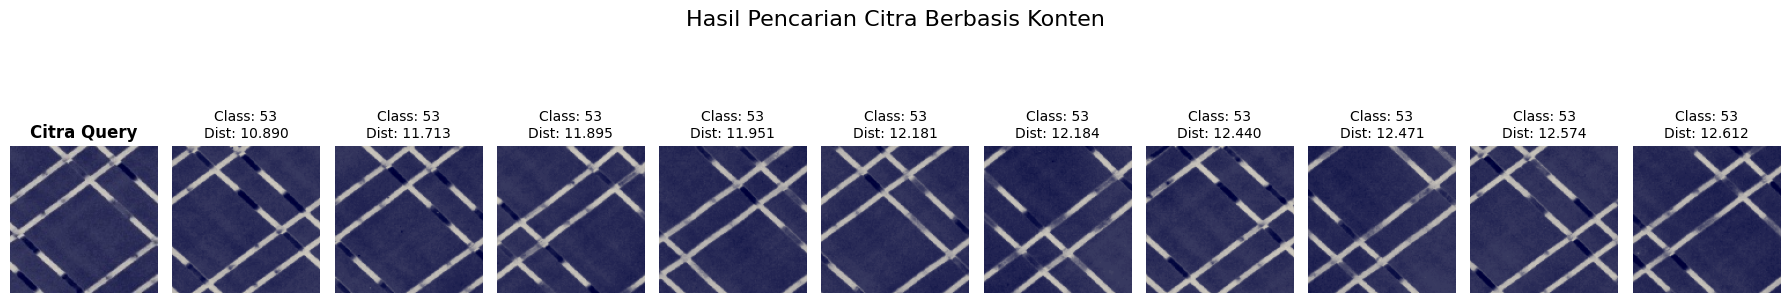

In [ ]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.distance import canberra

class CBIRSystem:
    def __init__(self, database_path, patch_size=128, n_color_clusters=64):
        """
        Inisialisasi sistem CBIR
        
        Parameters:
            database_path (str): Path ke folder database Brodatz
            patch_size (int): Ukuran potongan citra (default: 128)
            n_color_clusters (int): Jumlah cluster untuk kuantisasi warna (default: 64)
        """
        self.database_path = database_path
        self.patch_size = patch_size
        self.n_color_clusters = n_color_clusters
        self.image_descriptors = []
        self.image_patches = []
        self.class_labels = []
        self.patch_indices = []  # Untuk tracking patch dari citra mana
        self.kmeans_color = None
        self.feature_scaler = None
        self.nn_model = None
        
    def load_and_preprocess_images(self):
        """Memuat dan memproses citra dari database"""
        print("Memuat dan memproses citra dari database...")
        
        # Daftar semua file citra dalam format D{nomor}_COLORED.tif
        image_files = sorted([f for f in os.listdir(self.database_path) 
                           if f.endswith('_COLORED.tif') and f.startswith('D')])
        
        # Kumpulkan semua pixel untuk training K-Means
        all_pixels = []
        
        for class_idx, img_file in enumerate(image_files):
            img_path = os.path.join(self.database_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Gagal memuat citra: {img_file}")
                continue
                
            # Resize citra jika diperlukan
            if img.shape[0] != 640 or img.shape[1] != 640:
                img = cv2.resize(img, (640, 640))
                
            # Split citra menjadi 25 patch (5x5 grid)
            for i in range(5):
                for j in range(5):
                    y_start = i * self.patch_size
                    y_end = y_start + self.patch_size
                    x_start = j * self.patch_size
                    x_end = x_start + self.patch_size
                    
                    patch = img[y_start:y_end, x_start:x_end]
                    self.image_patches.append(patch)
                    self.class_labels.append(class_idx)
                    self.patch_indices.append((class_idx, i, j))
                    
                    # Kumpulkan pixel untuk training K-Means
                    pixels = patch.reshape(-1, 3).astype(np.float32)
                    sample_size = min(1000, len(pixels))  # Ambil sampel dari setiap patch
                    sample_indices = np.random.choice(len(pixels), sample_size, replace=False)
                    all_pixels.extend(pixels[sample_indices])
        
        # Training K-Means dengan pixel dari semua patch
        print("Training K-Means untuk kuantisasi warna...")
        all_pixels = np.array(all_pixels)
        sample_size = min(100000, len(all_pixels))
        sample_indices = np.random.choice(len(all_pixels), sample_size, replace=False)
        sample_pixels = all_pixels[sample_indices]
        
        self.kmeans_color = KMeans(n_clusters=self.n_color_clusters, random_state=42, n_init=10)
        self.kmeans_color.fit(sample_pixels)
        
        # Ekstrak fitur dari semua patch
        print("Ekstraksi fitur dari semua patch...")
        for patch in self.image_patches:
            features = self.extract_features(patch)
            self.image_descriptors.append(features)
                    
        self.image_descriptors = np.array(self.image_descriptors)
        self.class_labels = np.array(self.class_labels)
        print(f"Berhasil memuat {len(self.image_patches)} patch citra dari {len(image_files)} kelas.")
        
    def extract_features(self, image):
        """Mengekstrak fitur LBP dan warna dari citra"""
        # Konversi ke grayscale untuk LBP
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 1. Ekstrak fitur LBP dengan parameter yang lebih baik
        radius = 2
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Hitung histogram LBP
        n_bins = n_points + 2  # uniform bins + non-uniform bin
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        lbp_hist = lbp_hist.astype(float)
        lbp_hist /= (lbp_hist.sum() + 1e-8)  # Normalisasi dengan epsilon untuk stabilitas
        
        # 2. Hitung Maximum Run Length dari LBP
        max_run_length = self.calculate_max_run_length(lbp)
        
        # 3. Ekstrak fitur warna menggunakan K-Means
        color_features = self.extract_color_features(image)
        
        # 4. Ekstrak fitur statistik tambahan
        mean_colors = np.mean(image.reshape(-1, 3), axis=0)
        std_colors = np.std(image.reshape(-1, 3), axis=0)
        
        # Gabungkan semua fitur
        features = np.concatenate([
            lbp_hist,               # Histogram LBP
            [max_run_length],       # Maximum run length
            color_features,         # Histogram warna (K-Means)
            mean_colors,            # Rata-rata warna
            std_colors              # Standar deviasi warna
        ])
        
        return features
        
    def calculate_max_run_length(self, lbp_image):
        """Menghitung maximum run length dari citra LBP"""
        max_run = 0
        rows, cols = lbp_image.shape
        
        # Periksa arah horizontal
        for i in range(rows):
            current_val = lbp_image[i, 0]
            current_run = 1
            
            for j in range(1, cols):
                if lbp_image[i, j] == current_val:
                    current_run += 1
                else:
                    max_run = max(max_run, current_run)
                    current_val = lbp_image[i, j]
                    current_run = 1
            max_run = max(max_run, current_run)
                    
        # Periksa arah vertikal
        for j in range(cols):
            current_val = lbp_image[0, j]
            current_run = 1
            
            for i in range(1, rows):
                if lbp_image[i, j] == current_val:
                    current_run += 1
                else:
                    max_run = max(max_run, current_run)
                    current_val = lbp_image[i, j]
                    current_run = 1
            max_run = max(max_run, current_run)
                    
        return max_run
        
    def extract_color_features(self, image):
        """Mengekstrak fitur warna menggunakan K-Means"""
        # Ubah bentuk citra menjadi array pixel
        pixels = image.reshape(-1, 3).astype(np.float32)
        
        # Prediksi cluster untuk semua pixel
        clusters = self.kmeans_color.predict(pixels)
        
        # Buat histogram warna
        hist, _ = np.histogram(clusters, bins=self.n_color_clusters, range=(0, self.n_color_clusters-1))
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-8)  # Normalisasi dengan epsilon
        
        return hist
        
    def modified_canberra_distance(self, x, y):
        """Implementasi jarak Canberra yang dimodifikasi"""
        numerator = np.abs(x - y)
        denominator = np.abs(x) + np.abs(y) + 1e-8  # Tambahkan epsilon untuk stabilitas
        return np.sum(numerator / denominator)
        
    def train_model(self, distance_metric='canberra'):
        """Melatih model untuk pencarian citra"""
        print("Melatih model CBIR...")
        
        # Standarisasi fitur
        self.feature_scaler = StandardScaler()
        scaled_features = self.feature_scaler.fit_transform(self.image_descriptors)
        
        # Buat model Nearest Neighbors
        if distance_metric == 'canberra':
            self.nn_model = NearestNeighbors(n_neighbors=50, metric='canberra')
        elif distance_metric == 'euclidean':
            self.nn_model = NearestNeighbors(n_neighbors=50, metric='euclidean')
        else:  # manhattan
            self.nn_model = NearestNeighbors(n_neighbors=50, metric='manhattan')
            
        self.nn_model.fit(scaled_features)
        print(f"Model berhasil dilatih menggunakan metric: {distance_metric}")
        
    def query_image(self, query_image_path, k=10):
        """Mencari citra yang mirip dengan citra query"""
        query_img = cv2.imread(query_image_path)
        if query_img is None:
            print("Error: Gagal memuat citra query")
            return []
            
        # Resize citra query jika diperlukan
        if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
            query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
            
        # Ekstrak fitur
        query_features = self.extract_features(query_img)
        scaled_features = self.feature_scaler.transform([query_features])
        
        # Cari citra yang mirip
        distances, indices = self.nn_model.kneighbors(scaled_features, n_neighbors=k)
        
        # Kembalikan hasil
        results = []
        for i, dist in zip(indices[0], distances[0]):
            results.append({
                'patch': self.image_patches[i],
                'distance': dist,
                'class': self.class_labels[i]
            })
            
        return results
        
    def evaluate_retrieval(self, test_size=0.3, k_values=[5, 10, 15, 20]):
        """Evaluasi performa sistem dengan precision dan recall untuk berbagai k"""
        print("Evaluasi performa sistem...")
        
        # Gunakan stratified sampling untuk memastikan setiap kelas terwakili
        # Pilih beberapa patch dari setiap kelas untuk testing
        unique_classes = np.unique(self.class_labels)
        test_indices = []
        train_indices = []
        
        for class_id in unique_classes:
            class_indices = np.where(self.class_labels == class_id)[0]
            n_test = max(1, int(len(class_indices) * test_size))  # Minimal 1 sample per kelas
            
            test_class_indices = np.random.choice(class_indices, size=n_test, replace=False)
            train_class_indices = np.setdiff1d(class_indices, test_class_indices)
            
            test_indices.extend(test_class_indices)
            train_indices.extend(train_class_indices)
        
        test_indices = np.array(test_indices)
        train_indices = np.array(train_indices)
        
        # Standarisasi fitur
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        
        # Buat model evaluasi
        max_k = min(max(k_values), len(train_indices))
        eval_model = NearestNeighbors(n_neighbors=max_k, metric='canberra')
        eval_model.fit(scaled_features[train_indices])
        
        results = {}
        
        for k in k_values:
            if k > len(train_indices):
                print(f"Skipping k={k} karena lebih besar dari jumlah data training")
                continue
                
            precisions = []
            recalls = []
            
            for test_idx in test_indices:
                true_label = self.class_labels[test_idx]
                
                # Cari neighbors
                _, neighbor_indices = eval_model.kneighbors([scaled_features[test_idx]], n_neighbors=k)
                
                # Get actual neighbor labels from training set
                actual_neighbor_indices = train_indices[neighbor_indices[0]]
                neighbor_labels = self.class_labels[actual_neighbor_indices]
                
                # Hitung precision dan recall
                relevant_retrieved = np.sum(neighbor_labels == true_label)
                precision = relevant_retrieved / k
                
                # Hitung recall
                total_relevant_in_train = np.sum(self.class_labels[train_indices] == true_label)
                recall = relevant_retrieved / total_relevant_in_train if total_relevant_in_train > 0 else 0
                
                precisions.append(precision)
                recalls.append(recall)
                
            avg_precision = np.mean(precisions)
            avg_recall = np.mean(recalls)
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
            
            results[k] = {
                'precision': avg_precision,
                'recall': avg_recall,
                'f1_score': f1_score
            }
            
            print(f"Hasil evaluasi (k={k}):")
            print(f"  Rata-rata Precision: {avg_precision:.4f}")
            print(f"  Rata-rata Recall:    {avg_recall:.4f}")
            print(f"  F1-Score:           {f1_score:.4f}")
            print(f"  Jumlah data test:    {len(test_indices)}")
            print(f"  Jumlah data train:   {len(train_indices)}")
            print()
        
        return results
        
    def evaluate_by_same_image(self, k=10):
        """Evaluasi dengan menggunakan patch dari citra yang sama sebagai ground truth"""
        print("Evaluasi berdasarkan patch dari citra yang sama...")
        
        # Pilih beberapa patch secara acak untuk evaluasi
        test_indices = np.random.choice(len(self.image_patches), size=200, replace=False)
        
        precisions = []
        recalls = []
        
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        eval_model = NearestNeighbors(n_neighbors=k+1, metric='canberra')  # +1 karena akan mengabaikan diri sendiri
        eval_model.fit(scaled_features)
        
        for test_idx in test_indices:
            true_class = self.class_labels[test_idx]
            
            # Cari neighbors (termasuk diri sendiri)
            _, neighbor_indices = eval_model.kneighbors([scaled_features[test_idx]], n_neighbors=k+1)
            
            # Hapus diri sendiri dari hasil
            neighbor_indices = neighbor_indices[0][1:]  # Skip index pertama (diri sendiri)
            neighbor_labels = self.class_labels[neighbor_indices]
            
            # Hitung precision dan recall
            relevant_retrieved = np.sum(neighbor_labels == true_class)
            precision = relevant_retrieved / k
            
            # Total patch dari kelas yang sama (minus diri sendiri)
            total_relevant = np.sum(self.class_labels == true_class) - 1
            recall = relevant_retrieved / min(total_relevant, k) if total_relevant > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
        
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
        
        print(f"Evaluasi patch dari citra yang sama (k={k}):")
        print(f"  Rata-rata Precision: {avg_precision:.4f}")
        print(f"  Rata-rata Recall:    {avg_recall:.4f}")
        print(f"  F1-Score:           {f1_score:.4f}")
        
        return avg_precision, avg_recall, f1_score
    
    def simple_evaluation(self, k=10, n_samples=100):
        """Evaluasi sederhana untuk verifikasi sistem"""
        print(f"Evaluasi sederhana dengan {n_samples} sampel...")
        
        # Pilih sampel secara acak
        sample_indices = np.random.choice(len(self.image_patches), size=n_samples, replace=False)
        
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        eval_model = NearestNeighbors(n_neighbors=k+1, metric='canberra')
        eval_model.fit(scaled_features)
        
        precisions = []
        
        for sample_idx in sample_indices:
            true_class = self.class_labels[sample_idx]
            
            # Cari neighbors (termasuk diri sendiri)
            _, neighbor_indices = eval_model.kneighbors([scaled_features[sample_idx]], n_neighbors=k+1)
            
            # Hapus diri sendiri dari hasil
            neighbor_indices = neighbor_indices[0][1:]  # Skip index pertama (diri sendiri)
            neighbor_labels = self.class_labels[neighbor_indices]
            
            # Hitung precision
            relevant_retrieved = np.sum(neighbor_labels == true_class)
            precision = relevant_retrieved / k
            precisions.append(precision)
        
        avg_precision = np.mean(precisions)
        print(f"Rata-rata Precision (evaluasi sederhana): {avg_precision:.4f}")
        
        # Tampilkan distribusi precision
        precision_dist = np.bincount([int(p*k) for p in precisions], minlength=k+1)
        for i, count in enumerate(precision_dist):
            if count > 0:
                print(f"  {i}/{k} relevan: {count} sampel ({count/n_samples*100:.1f}%)")
        
        return avg_precision
        
    def visualize_results(self, query_image_path, results):
        """Visualisasi hasil pencarian"""
        query_img = cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB)
        if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
            query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
        
        n_results = min(10, len(results))
        plt.figure(figsize=(18, 4))
        plt.suptitle("Hasil Pencarian Citra Berbasis Konten", fontsize=16)
        
        # Tampilkan citra query
        plt.subplot(1, n_results+1, 1)
        plt.imshow(query_img)
        plt.title("Citra Query", fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Tampilkan hasil
        for i, result in enumerate(results[:n_results]):
            plt.subplot(1, n_results+1, i+2)
            img = cv2.cvtColor(result['patch'], cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Class: {result['class']}\nDist: {result['distance']:.3f}", fontsize=10)
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()
        
    def analyze_feature_importance(self):
        """Analisis pentingnya fitur"""
        features = self.image_descriptors
        
        # Hitung statistik fitur
        feature_means = np.mean(features, axis=0)
        feature_stds = np.std(features, axis=0)
        
        # Identifikasi komponen fitur
        lbp_size = 18  # n_points + 2 untuk uniform LBP
        run_length_size = 1
        color_size = self.n_color_clusters
        mean_color_size = 3
        std_color_size = 3
        
        print("Analisis Fitur:")
        print(f"- LBP Histogram: {lbp_size} fitur")
        print(f"- Maximum Run Length: {run_length_size} fitur")
        print(f"- Color Histogram: {color_size} fitur")
        print(f"- Mean Colors: {mean_color_size} fitur")
        print(f"- Std Colors: {std_color_size} fitur")
        print(f"Total fitur: {len(feature_means)}")

# Contoh penggunaan yang diperbaiki
if __name__ == "__main__":
    # Inisialisasi sistem dengan parameter yang lebih baik
    database_path = "./Colored_Brodatz"
    cbir = CBIRSystem(database_path, n_color_clusters=64)  # Meningkatkan jumlah cluster warna
    
    # Memuat dan memproses citra
    cbir.load_and_preprocess_images()
    
    # Analisis fitur
    cbir.analyze_feature_importance()
    
    # Melatih model dengan jarak Canberra
    cbir.train_model(distance_metric='canberra')
    
    # Evaluasi performa dengan berbagai k
    results = cbir.evaluate_retrieval(test_size=0.3, k_values=[5, 10, 15, 20])
    
    # Evaluasi tambahan berdasarkan patch dari citra yang sama
    cbir.evaluate_by_same_image(k=10)
    
    # Evaluasi sederhana untuk verifikasi
    print("\n=== Evaluasi Sederhana ===")
    cbir.simple_evaluation(k=10)
    
    # Contoh pencarian
    query_path = "./Colored_Brodatz/D54_COLORED.tif"
    if os.path.exists(query_path):
        # Buat patch query (ambil patch tengah)
        query_img = cv2.imread(query_path)
        if query_img is not None:
            query_img = cv2.resize(query_img, (640, 640))
            # Ambil patch tengah (2,2)
            patch = query_img[256:384, 256:384]  # Patch tengah dari grid 5x5
            cv2.imwrite("query_patch_lbp2.jpg", patch)
            
            results = cbir.query_image("query_patch_lbp2.jpg", k=10)
            cbir.visualize_results("query_patch_lbp2.jpg", results)
    else:
        print(f"Citra query {query_path} tidak ditemukan")

In [9]:
def visualize_color_features(self, image_path, save_analysis=False):
    """Visualisasi dan analisis fitur warna dari sebuah citra"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Gagal memuat citra")
        return
        
    # Resize jika diperlukan
    if img.shape[0] != self.patch_size or img.shape[1] != self.patch_size:
        img = cv2.resize(img, (self.patch_size, self.patch_size))
    
    # Extract color features
    color_hist = self.extract_color_features(img)
    pixels = img.reshape(-1, 3).astype(np.float32)
    mean_colors = np.mean(pixels, axis=0)
    std_colors = np.std(pixels, axis=0)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Analisis Fitur Warna - CBIR System', fontsize=16, fontweight='bold')
    
    # 1. Original image
    axes[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0,0].set_title('Citra Asli', fontweight='bold')
    axes[0,0].axis('off')
    
    # 2. Color histogram (K-Means clusters)
    axes[0,1].bar(range(len(color_hist)), color_hist, color='steelblue', alpha=0.7)
    axes[0,1].set_title('Histogram Warna (K-Means Clusters)', fontweight='bold')
    axes[0,1].set_xlabel('Cluster Index')
    axes[0,1].set_ylabel('Normalized Frequency')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. RGB distribution
    colors = ['red', 'green', 'blue']
    channels = ['Red', 'Green', 'Blue']
    for i in range(3):
        hist, bins = np.histogram(img[:,:,i].ravel(), bins=50, range=[0,256])
        hist = hist.astype(float) / hist.sum()
        axes[0,2].plot(bins[:-1], hist, color=colors[i], alpha=0.7, label=channels[i])
    axes[0,2].set_title('Distribusi RGB', fontweight='bold')
    axes[0,2].set_xlabel('Intensity Value')
    axes[0,2].set_ylabel('Normalized Frequency')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Mean color visualization
    mean_color_patch = np.ones((50, 50, 3), dtype=np.uint8)
    mean_color_patch[:,:] = mean_colors.astype(np.uint8)
    axes[1,0].imshow(mean_color_patch)
    axes[1,0].set_title(f'Warna Rata-rata\nRGB: ({mean_colors[2]:.1f}, {mean_colors[1]:.1f}, {mean_colors[0]:.1f})', fontweight='bold')
    axes[1,0].axis('off')
    
    # 5. Color variance visualization
    axes[1,1].bar(['Red', 'Green', 'Blue'], std_colors, color=['red', 'green', 'blue'], alpha=0.7)
    axes[1,1].set_title('Standar Deviasi Warna', fontweight='bold')
    axes[1,1].set_ylabel('Standard Deviation')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Dominant colors from K-Means
    # Get dominant clusters
    clusters = self.kmeans_color.predict(pixels)
    dominant_indices = np.argsort(color_hist)[-8:][::-1]  # Top 8 clusters
    dominant_colors = self.kmeans_color.cluster_centers_[dominant_indices]
    
    # Create color palette
    palette = np.ones((50, 400, 3), dtype=np.uint8)
    for i, color in enumerate(dominant_colors):
        start_x = i * 50
        end_x = start_x + 50
        palette[:, start_x:end_x] = color.astype(np.uint8)
    
    axes[1,2].imshow(palette)
    axes[1,2].set_title('8 Warna Dominan (K-Means)', fontweight='bold')
    axes[1,2].axis('off')
    
    plt.tight_layout()
    
    if save_analysis:
        plt.savefig('color_feature_analysis.png', dpi=150, bbox_inches='tight')
        print("Analisis fitur warna disimpan sebagai 'color_feature_analysis.png'")
    
    plt.show()
    
    # Print detailed statistics
    print("\n=== ANALISIS DETAIL FITUR WARNA ===")
    print(f"Dimensi citra: {img.shape}")
    print(f"Total pixel: {img.shape[0] * img.shape[1]}")
    print(f"\nFitur Warna Rata-rata (BGR):")
    print(f"  Blue:  {mean_colors[0]:.2f}")
    print(f"  Green: {mean_colors[1]:.2f}")
    print(f"  Red:   {mean_colors[2]:.2f}")
    print(f"\nFitur Warna Std Deviasi (BGR):")
    print(f"  Blue:  {std_colors[0]:.2f}")
    print(f"  Green: {std_colors[1]:.2f}")
    print(f"  Red:   {std_colors[2]:.2f}")
    print(f"\nHistogram Warna (K-Means):")
    print(f"  Jumlah cluster: {len(color_hist)}")
    print(f"  Cluster dominan: {np.argmax(color_hist)} (freq: {np.max(color_hist):.4f})")
    print(f"  Entropy: {-np.sum(color_hist * np.log(color_hist + 1e-8)):.4f}")
    
    return {
        'color_histogram': color_hist,
        'mean_colors': mean_colors,
        'std_colors': std_colors,
        'dominant_colors': dominant_colors
    }

def compare_color_features(self, image_paths, titles=None):
    """Membandingkan fitur warna dari beberapa citra"""
    import matplotlib.pyplot as plt
    
    n_images = len(image_paths)
    if titles is None:
        titles = [f"Image {i+1}" for i in range(n_images)]
    
    fig, axes = plt.subplots(3, n_images, figsize=(4*n_images, 12))
    if n_images == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Perbandingan Fitur Warna', fontsize=16, fontweight='bold')
    
    all_features = []
    
    for i, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        if img.shape[0] != self.patch_size or img.shape[1] != self.patch_size:
            img = cv2.resize(img, (self.patch_size, self.patch_size))
        
        # Extract features
        color_hist = self.extract_color_features(img)
        pixels = img.reshape(-1, 3).astype(np.float32)
        mean_colors = np.mean(pixels, axis=0)
        std_colors = np.std(pixels, axis=0)
        
        all_features.append({
            'color_hist': color_hist,
            'mean_colors': mean_colors,
            'std_colors': std_colors
        })
        
        # Show original image
        axes[0,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0,i].set_title(titles[i], fontweight='bold')
        axes[0,i].axis('off')
        
        # Show color histogram
        axes[1,i].bar(range(len(color_hist)), color_hist, color='steelblue', alpha=0.7)
        axes[1,i].set_title(f'Histogram Warna')
        axes[1,i].set_ylabel('Frequency' if i == 0 else '')
        
        # Show color statistics
        x_pos = ['B', 'G', 'R']
        axes[2,i].bar(x_pos, mean_colors, alpha=0.7, color=['blue', 'green', 'red'])
        axes[2,i].set_title('Mean Colors')
        axes[2,i].set_ylabel('Mean Value' if i == 0 else '')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison
    print("\n=== PERBANDINGAN FITUR WARNA ===")
    for i, (path, features) in enumerate(zip(image_paths, all_features)):
        print(f"\n{titles[i]} ({path}):")
        print(f"  Mean BGR: {features['mean_colors']}")
        print(f"  Std BGR:  {features['std_colors']}")
        print(f"  Color entropy: {-np.sum(features['color_hist'] * np.log(features['color_hist'] + 1e-8)):.4f}")

def analyze_color_feature_importance(self):
    """Analisis pentingnya fitur warna dalam sistem"""
    print("\n=== ANALISIS PENTINGNYA FITUR WARNA ===")
    
    # Identifikasi komponen fitur
    lbp_size = 18
    run_length_size = 1
    color_hist_size = self.n_color_clusters
    mean_color_size = 3
    std_color_size = 3
    
    # Extract color features only
    color_features = self.image_descriptors[:, lbp_size + run_length_size:]
    color_hist_features = color_features[:, :color_hist_size]
    mean_color_features = color_features[:, color_hist_size:color_hist_size + mean_color_size]
    std_color_features = color_features[:, color_hist_size + mean_color_size:]
    
    print(f"Total fitur warna: {color_features.shape[1]}")
    print(f"  - Color Histogram: {color_hist_size} fitur")
    print(f"  - Mean Colors: {mean_color_size} fitur")
    print(f"  - Std Colors: {std_color_size} fitur")
    
    # Analyze variance and discriminative power
    color_hist_var = np.var(color_hist_features, axis=0)
    mean_color_var = np.var(mean_color_features, axis=0)
    std_color_var = np.var(std_color_features, axis=0)
    
    print(f"\nVariansi fitur:")
    print(f"  - Color Histogram: mean={np.mean(color_hist_var):.6f}, max={np.max(color_hist_var):.6f}")
    print(f"  - Mean Colors: {mean_color_var}")
    print(f"  - Std Colors: {std_color_var}")
    
    # Find most discriminative color clusters
    top_clusters = np.argsort(color_hist_var)[-10:][::-1]
    print(f"\n10 cluster warna paling diskriminatif: {top_clusters}")
    print(f"Variansi mereka: {color_hist_var[top_clusters]}")

# Tambahkan method ini ke class CBIRSystem
def add_color_visualization_methods(cbir_instance):
    """Helper function to add color visualization methods to existing CBIR instance"""
    import types
    
    cbir_instance.visualize_color_features = types.MethodType(visualize_color_features, cbir_instance)
    cbir_instance.compare_color_features = types.MethodType(compare_color_features, cbir_instance)
    cbir_instance.analyze_color_feature_importance = types.MethodType(analyze_color_feature_importance, cbir_instance)

# Contoh penggunaan:
"""
# Setelah inisialisasi dan training model CBIR
add_color_visualization_methods(cbir)

# Analisis fitur warna untuk satu citra
cbir.visualize_color_features("query_patch_lbp2.jpg", save_analysis=True)

# Bandingkan fitur warna beberapa citra
query_paths = ["./Colored_Brodatz/D1_COLORED.tif", "./Colored_Brodatz/D2_COLORED.tif"]
cbir.compare_color_features(query_paths, ["Texture 1", "Texture 2"])

# Analisis pentingnya fitur warna
cbir.analyze_color_feature_importance()
"""

'\n# Setelah inisialisasi dan training model CBIR\nadd_color_visualization_methods(cbir)\n\n# Analisis fitur warna untuk satu citra\ncbir.visualize_color_features("query_patch_lbp2.jpg", save_analysis=True)\n\n# Bandingkan fitur warna beberapa citra\nquery_paths = ["./Colored_Brodatz/D1_COLORED.tif", "./Colored_Brodatz/D2_COLORED.tif"]\ncbir.compare_color_features(query_paths, ["Texture 1", "Texture 2"])\n\n# Analisis pentingnya fitur warna\ncbir.analyze_color_feature_importance()\n'

Analisis fitur warna disimpan sebagai 'color_feature_analysis.png'


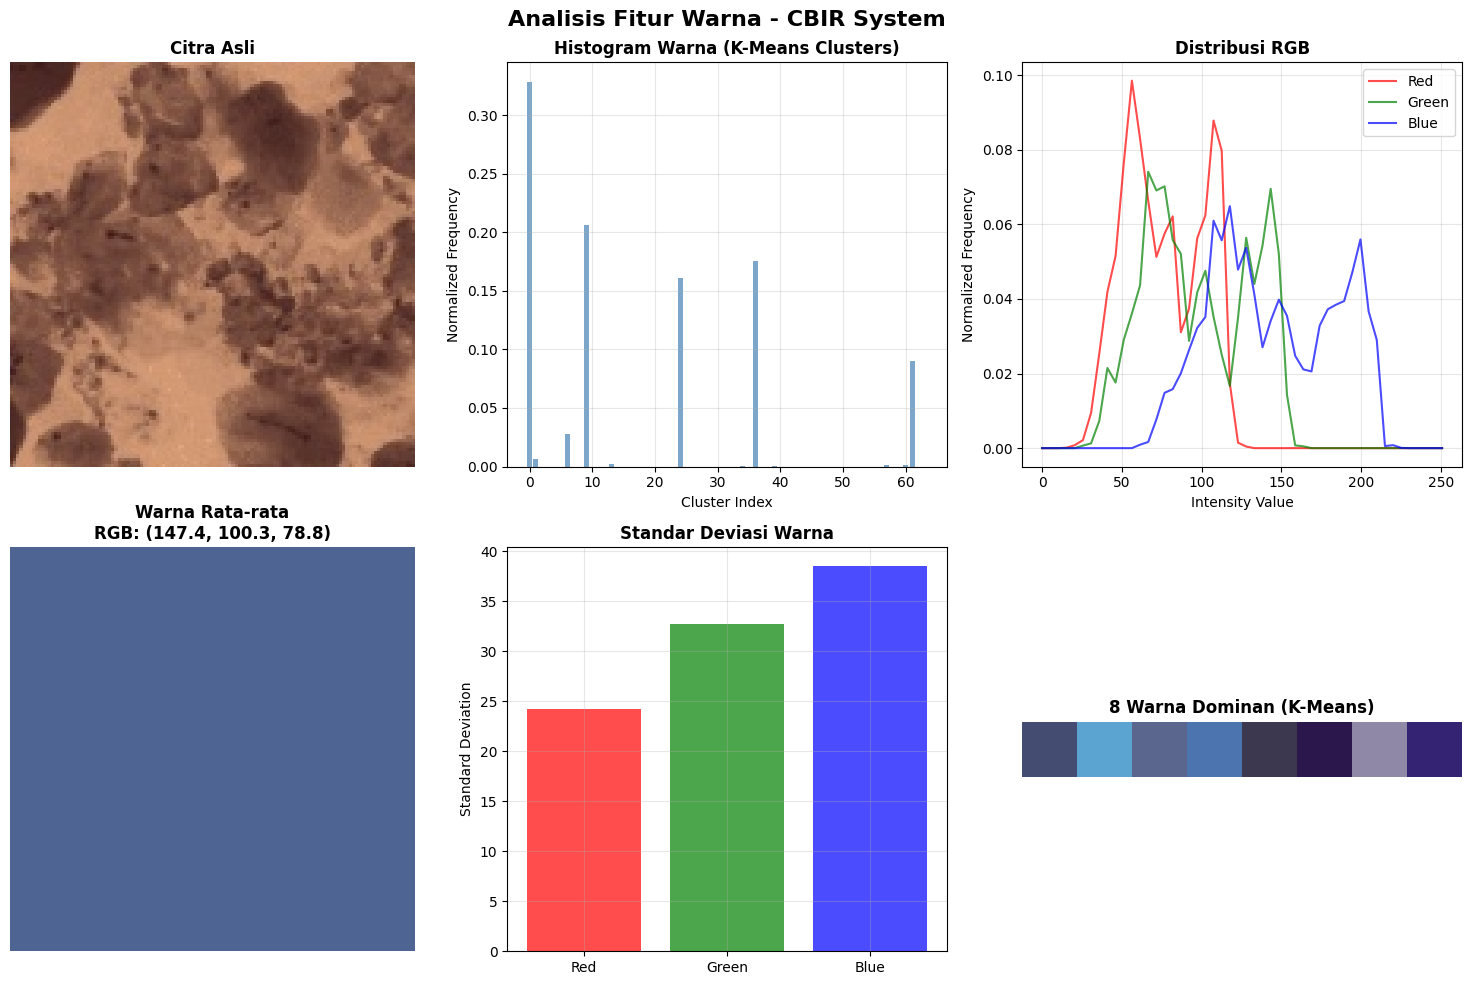


=== ANALISIS DETAIL FITUR WARNA ===
Dimensi citra: (128, 128, 3)
Total pixel: 16384

Fitur Warna Rata-rata (BGR):
  Blue:  78.80
  Green: 100.29
  Red:   147.36

Fitur Warna Std Deviasi (BGR):
  Blue:  24.18
  Green: 32.72
  Red:   38.49

Histogram Warna (K-Means):
  Jumlah cluster: 64
  Cluster dominan: 0 (freq: 0.3288)
  Entropy: 1.6720

=== ANALISIS PENTINGNYA FITUR WARNA ===
Total fitur warna: 70
  - Color Histogram: 64 fitur
  - Mean Colors: 3 fitur
  - Std Colors: 3 fitur

Variansi fitur:
  - Color Histogram: mean=0.004797, max=0.010739
  - Mean Colors: [2243.29104912 1732.79441961 1734.80750333]
  - Std Colors: [224.90330467 293.9976245  233.66045682]

10 cluster warna paling diskriminatif: [ 7 25 11 34 14 29 50 21 32 41]
Variansi mereka: [0.01073887 0.01027248 0.00995986 0.00991016 0.00903992 0.00836636
 0.00831026 0.00807457 0.00803151 0.00753526]


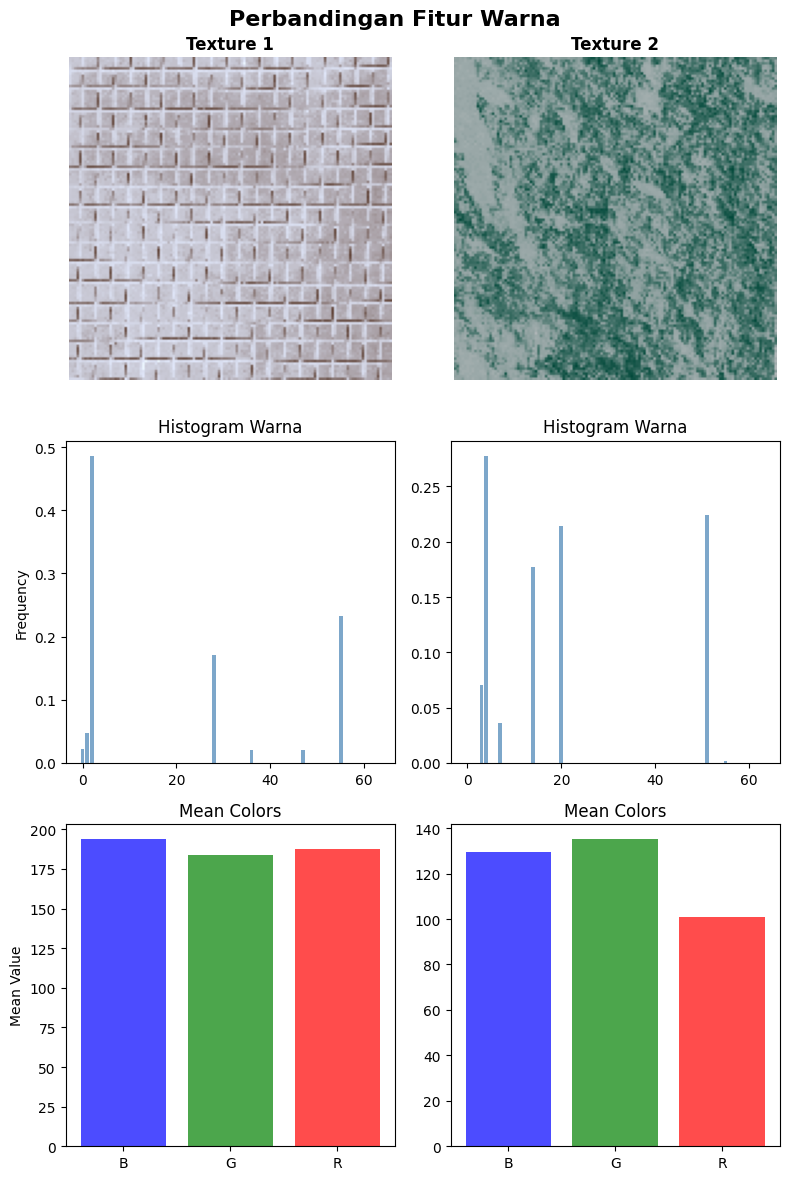


=== PERBANDINGAN FITUR WARNA ===

Texture 1 (./Colored_Brodatz/D1_COLORED.tif):
  Mean BGR: [193.67535 183.9502  187.47021]
  Std BGR:  [34.727615 29.326193 22.953426]
  Color entropy: 1.3848

Texture 2 (./Colored_Brodatz/D2_COLORED.tif):
  Mean BGR: [129.55078 135.07324 100.79266]
  Std BGR:  [29.128138 25.087729 40.355656]
  Color entropy: 1.6428


In [ ]:
# Setelah cbir.train_model()
add_color_visualization_methods(cbir)

# Visualisasi fitur warna
cbir.visualize_color_features("query_patch_lbp2.jpg", save_analysis=True)

# Analisis pentingnya fitur warna  
cbir.analyze_color_feature_importance()

# Bandingkan fitur warna
paths = ["./Colored_Brodatz/D19_COLORED.tif", "./Colored_Brodatz/D12_COLORED.tif"]
cbir.compare_color_features(paths, ["Texture 1", "Texture 2"])